In [ ]:
# DROWSINESS DETECTION USING DLIB

# Eye Aspect Ratio = EAR < 0.26 -> DROWSY

#notCorrectDf
#(15057, 5)
#CorrectDf
#(26736, 5)

#ACCURACY = 26736/41793 = 0.6397243557533558

In [1]:
import pandas as pd
import re
import os
import numpy as np
import dlib
import cv2


In [ ]:
# install dlib
!apt update
!apt install -y cmake
!pip install dlib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,027 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,589 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages

In [2]:
#mount google drive for having access to the dataset in google colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#DOWNLOAD SHAPE_PREDICTOR AND CNN_FACE_DETECTOR, INITIALIZE DETECTORS AND PREDICTORS

#download and unzip shape_predictor_68_face_landmarks
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

#download and unzip CNN face detector -> only with GPU
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

!bunzip2 /content/mmod_human_face_detector.dat.bz2

cnnFile = "/content/mmod_human_face_detector.dat"

#----dlib functionalities----
#use either hog_face_detector or cnn_detector
hog_face_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1(cnnFile)

#landmark detector
dlib_facelandmark = dlib.shape_predictor(datFile)

--2023-04-03 22:17:22--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.3’

shape_predictor_68_ 100%[===================>]  61.07M  16.1MB/s    in 5.0s    

2023-04-03 22:17:27 (12.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.3’ saved [64040097/64040097]

bunzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.
--2023-04-03 22:17:28--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2.3’

mmod_human_face_det 100%[===================>] 678.43K  1.50MB/s    in 0.4s    

2023-0

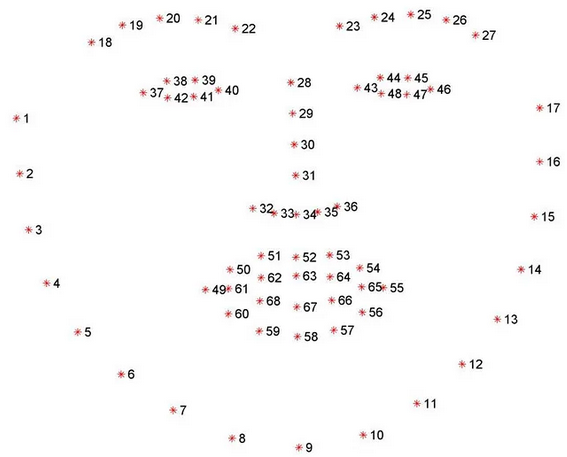

In [3]:
# predefined 68 landmarks that dlib_facelandmark can detect

from google.colab.patches import cv2_imshow

path_landmarks_predefined ='/content/drive/MyDrive/68facial_landmarks_predefined_II.png'
landmarks_predefined_img = cv2.imread(os.path.join(path_landmarks_predefined), cv2.IMREAD_UNCHANGED)
cv2_imshow(landmarks_predefined_img)

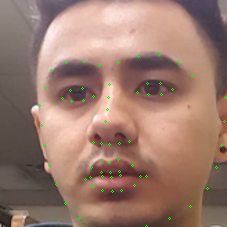

In [ ]:
# DEMO OF DLIB FACE DETECTION OF ONE IMAGE WITH CNN_DETECTOR

from google.colab.patches import cv2_imshow

testimagepath = '/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/Non Drowsy/d0590.png'
testimage = cv2.imread(os.path.join(testimagepath),cv2.IMREAD_UNCHANGED)

#faceList = hog_face_detector(testimage)
faceList = cnn_detector(testimage)

for singleFace in faceList:
  face_landmarks = dlib_facelandmark(testimage, singleFace.rect)
  
  #draw point for every face_landmark point
  for n in range(0, 68):
    x = face_landmarks.part(n).x
    y = face_landmarks.part(n).y
    cv2.circle(testimage, (x, y), 1, (0, 255, 0), 1)
cv2_imshow(testimage)

# Neuer Abschnitt

In [ ]:
from scipy.spatial import distance

#calculate the eye aspect ratio
def calculate_EAR(eye):
  A = distance.euclidean(eye[1], eye[5])
  B = distance.euclidean(eye[2], eye[4])
  C = distance.euclidean(eye[0], eye[3])
  eye_aspect_ratio = (A+B)/(2.0*C)
  return eye_aspect_ratio


In [ ]:
# FUNCTION ADDS A PREDICTION DROWSY OR NON_DROWSY TO PREDICTIONS LIST

def predictLabelWithEAR(dlib_facelandmark, faces, grayscale, predictions):
  #go through all faces that have been detected by the hog_face_detector
  for face in faces:
    face_landmarks = dlib_facelandmark(grayscale, face.rect)
    leftEye = []
    rightEye = []

    #save landmarks of the eyes
    #leftEye
    for n in range(36, 42):
      x = face_landmarks.part(n).x
      y = face_landmarks.part(n).y
      #cv2.circle(image, (x, y), 1, (0, 0, 255), 1)
      leftEye.append((x,y))
    
    #rightEye
    for n in range(42, 48):
      x = face_landmarks.part(n).x
      y = face_landmarks.part(n).y
      #cv2.circle(image, (x, y), 1, (0, 255, 0), 1)
      rightEye.append((x,y))
    
    #calculate eye aspect ratio for every eye
    left_ear = calculate_EAR(leftEye)
    right_ear = calculate_EAR(rightEye)

    ear = (left_ear+right_ear)/2
    ear = round(ear, 2)

    #one face detected in the image
    if len(faces)==1:
      #if eye aspect ratio is below a threshold - classify as drowsy
      if ear < 0.26:
        #drowsy
        predictions.append(0)
        return 0
      else:
        #not drowsy
        predictions.append(1)
        return 0
    else:
      #multiple faces detected in the image
      predictions.append(2)
      return 0


In [ ]:
# CREATE A DATAFRAME OF ALL PICTURES IN THE DATASET WITH REAL LABEL AND PREDICTED LABEL BY EAR

# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []

#list of predicted labels by the eye aspect ratio
predictions = []

#for the person_ID - identification criteria of participant
pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?')

data_dir = "/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/"
#data_dir = "/content/drive/MyDrive/smalltest/testDDD/"

for class_name in os.listdir(data_dir):  #goes through all folders in DDD folder
  for imageName in os.listdir(data_dir+class_name):  #goes through all files in both folders and updates file path and labels
    #correct label
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    #image path
    image_path.append(os.path.join(data_dir, class_name, imageName))
    #file name
    file_name.append(imageName)
    #personID
    person_ID.append(pattern.findall(imageName)[0])  #identification of participant

    #prediction of the label by landmark
    image = cv2.imread(os.path.join(data_dir, class_name, imageName),cv2.IMREAD_UNCHANGED)
    #grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #faces = hog_face_detector(image)
    faces = cnn_detector(image)
    if len(faces)==0:
      #no face was detected
      predictions.append(-1)
    else:
      #face was detected - predict the label
      predictLabelWithEAR(dlib_facelandmark, faces, image, predictions)

#dataframe with path, label, predicted label, file name, person_ID of all Persons
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['predlabel'] = predictions
df['name'] = file_name
df['person'] = person_ID

print('df')
print(df)
print('df shape')
print(df.shape)

df
                                                  images  label  predlabel  \
0      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
1      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
2      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
3      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
4      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
...                                                  ...    ...        ...   
41788  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41789  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41790  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41791  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41792  /content/drive/MyDrive/newdata/Driver Drowsine...      0          1   

             name person  
0      zc0353.png     zc  
1     

In [ ]:
# COMPARISON CLASSIFIED WRONG VS CLASSIFIED CORRECTLY

#classiefied wrong by eye aspect ratio
notCorrectDf = df[df['label']!=df['predlabel']]
print('notCorrectDf')
print(notCorrectDf.shape)

#classified correctly by eye aspect ratio
CorrectDf = df[df['label']==df['predlabel']]
print('CorrectDf')
print(CorrectDf.shape)

notCorrectDf
(15057, 5)
CorrectDf
(26736, 5)


In [ ]:
accuracy = CorrectDf.shape[0]/df.shape[0]
print('accuracy')
print(accuracy)

accuracy
0.6397243557533558


In [ ]:
notCorrectDf.groupby('person').size()

person
A      350
B       65
C      326
D       88
E      955
F      395
G       16
H      494
I      125
J        1
K      450
L      242
M        5
N       13
O      859
P       20
Q      210
R      168
S       37
T       78
U      225
V       76
W      978
X      313
Y       64
ZA      47
ZB     783
ZC    1327
a      189
b       20
c        4
d      186
e       21
g        8
h       94
i      730
j       68
k       40
l        6
m      380
n      658
o        6
p      187
q       13
r       38
s       56
u       24
v      670
w        2
x     1103
y      518
za    1016
zb     280
zc      30
dtype: int64

In [ ]:
#error face couldnt be detected
noFaceDetection = notCorrectDf[notCorrectDf['predlabel']==-1]
print('noFaceDetection')
print(noFaceDetection.shape)
print('-----')
noFaceDetection.groupby('person').size()

noFaceDetection
(961, 5)
-----


person
E     908
G       5
U       1
ZB     25
c       1
e      21
dtype: int64

In [ ]:
#face detected but classified wrong
classifiedWrong = notCorrectDf[notCorrectDf['predlabel']!=-1]

classifiedWrong = classifiedWrong[classifiedWrong['predlabel']!=2]

print('classifiedWrong')
print(classifiedWrong.shape)
print('-----')
classifiedWrong.groupby('person').size()

classifiedWrong
(14061, 5)
-----


person
A      350
B       65
C      326
D       88
E       47
F      395
G       11
H      487
I      125
J        1
K      450
L      242
M        5
N       13
O      859
P       20
Q      210
R      168
S       37
T       51
U      224
V       76
W      978
X      313
Y       64
ZA      47
ZB     758
ZC    1327
a      189
b       20
c        3
d      186
g        8
h       94
i      730
j       68
k       40
l        6
m      380
n      658
o        6
p      187
q       13
r       38
s       56
u       24
v      670
w        2
x     1103
y      518
za    1015
zb     280
zc      30
dtype: int64

In [ ]:
#correct labels of the wrong classified
classifiedWrong.groupby('label').size()

#try out ear < 0.27

label
0    7737
1    6324
dtype: int64

In [ ]:
#multiple faces detected but only one face per image
multipleFacesDetected = notCorrectDf[notCorrectDf['predlabel']==2]
print('multipleFacesDetected')
print(multipleFacesDetected.shape)
print('-----')
multipleFacesDetected.groupby('person').size()

multipleFacesDetected
(35, 5)
-----


person
H      7
T     27
za     1
dtype: int64

In [ ]:
accuracy = CorrectDf.shape[0]/df.shape[0]
print('accuracy')
print(accuracy)

accuracy
0.6397243557533558
